### Twitter API Scraping and Data Wrangling Case Study
Timothy Short

In [116]:
import pandas as pd
import requests
import json
import tweepy #pip install tweepy
import time
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

#### Step 1: Load the datasets

In [68]:
#load archived tweets
df_tweets = pd.read_csv('twitter-archive-enhanced.csv')
print(df_tweets.shape[0])
df_tweets.head(1)

2356


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None


In [69]:
#download dataset for images
images_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
images = requests.get(images_url)
with open('image_predictions.tsv', mode='wb') as file:
    file.write(images.content)
df_predictions = pd.read_csv('image_predictions.tsv', delimiter='\t')
df_predictions.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


<hr>
#### Step 2: Investigate and Observe the Tweets Dataset

In [70]:
df_tweets.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https:/...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https:/...",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [71]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [72]:
#count number of ratings with denominator other than 10
df_tweets[df_tweets['rating_denominator']!=10].shape[0]

23

In [73]:
#count the number of outlier ratings (greater than 15)
df_tweets[df_tweets['rating_numerator'] > 15]['rating_numerator'].get_values()

array([  17,  420,  666,  182,  960,   75,   84,   24,   75,   27,  165,
       1776,  204,   50,   99,   80,   45,   60,   44,  143,  121,   20,
         26,  144,   88,  420])

In [74]:
df_tweets[df_tweets['name'] == 'None'].shape[0]

745

In [75]:
#Count the number of photos with no dog stage
df_tweets.query(
    'doggo == "None"'  and 'floofer == "None"' and 'pupper == "None"' and 'puppo == "None"'
        ).shape[0]

2326

In [76]:
#Count the values of dog stages
print(df_tweets[df_tweets['doggo'] != "None"]['doggo'].value_counts())
print(df_tweets[df_tweets['floofer'] != "None"]['floofer'].value_counts())
print(df_tweets[df_tweets['pupper'] != "None"]['pupper'].value_counts())
print(df_tweets[df_tweets['puppo'] != "None"]['puppo'].value_counts())

doggo    97
Name: doggo, dtype: int64
floofer    10
Name: floofer, dtype: int64
pupper    257
Name: pupper, dtype: int64
puppo    30
Name: puppo, dtype: int64


In [77]:
#Count the number of with multiple dog stages
dog_stages = ['doggo', 'floofer', 'pupper', 'puppo']
dog_multiples = []
for index, dog_stage in enumerate(dog_stages):
    for i in range(index+1, len(dog_stages)):
        temp_array = df_tweets.query(dog_stage + ' != "None" and ' + dog_stages[i] + ' != "None"').index.get_values()
        for temp in temp_array:
            dog_multiples.append(temp)

dog_multiples.sort()
df_tweets.iloc[dog_multiples][['text', 'doggo', 'floofer', 'pupper', 'puppo']].shape[0]

14

#### Observations & Data Issues

*Quality Issues*
- 181 of the tweets were "retweeted" and 78 of the tweets were "replies"
- `tweet_id` is as an Integer; should be a String
- `timestamp` field is a String (not in DateTime), same is true for `retweeted_status_timestamp`
- `rating_denominator` has 23 records with a value other than 10
- `rating_numerator` has widely ranging values
- `name` has 745 records with 'None' as the dog name
- There are 2326 records where the dog stage was not identified (as `doggo, floofer, pupper, puppo`)
- There are 14 records with multiple dog stages identified
- `expanded_urls` (the URL of the photo) is missing in 59 tweets

*Tidy Issues*
- `text` field contains multiple data points (actual tweet text, rating, url, and dog name)
- `expanded_urls` contains some records with multiple URLs
- each tweet should reflect only one dog stage; `doggo, floofer, pupper, puppo` fields could be combined into one column

<hr>
#### Step 3: Clean the Tweets dataset

In [87]:
#copy the tweets dataframe
df_tweets_copy = df_tweets.copy()

**Define:** Remove rows of missing data and update data types

**Code:**

In [88]:
#remove retweets
df_tweets_copy = df_tweets_copy[df_tweets_copy['retweeted_status_id'].isnull()]

#remove replies
df_tweets_copy = df_tweets_copy[df_tweets_copy['in_reply_to_status_id'].isnull()]

#remove tweets with no photos
df_tweets_copy = df_tweets_copy[df_tweets_copy['expanded_urls'].notnull()]

#change tweet_id to String
df_tweets_copy['tweet_id'] = df_tweets_copy['tweet_id'].astype(str)

#change timestampe to DateTime
df_tweets_copy['timestamp'] = pd.to_datetime(df_tweets_copy['timestamp'])

df_tweets_copy.reset_index(drop=True, inplace=True)

**Define:** Clean messy data of ratings, dog stages

**Code:**

In [89]:
#clean ratings
#look for denominators other than 10
pd.options.display.max_colwidth = 150
df_tweets_copy[df_tweets_copy['rating_denominator'] != 10][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
338,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
402,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t ...,24,7
698,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
851,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
902,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
946,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
983,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1009,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1034,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1054,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50


In [90]:
#manually update errors - based on denominator
df_tweets_copy.set_value(851, 'rating_numerator', 9);
df_tweets_copy.set_value(946, 'rating_numerator', 13);
df_tweets_copy.set_value(1423, 'rating_numerator', 10);
df_tweets_copy.set_value(2073, 'rating_numerator', 9);
df_tweets_copy.set_value([851, 946, 1423, 2073], 'rating_denominator', 10);

df_tweets_copy.drop(402, inplace=True)
df_tweets_copy.reset_index(drop=True, inplace=True)

#update ratings for photos of multiple dogs - look for deniminators greater than 10 in multiples of 10
for row in df_tweets_copy[df_tweets_copy['rating_denominator'] != 10][['text', 'rating_numerator', 'rating_denominator']].itertuples():
    divisor = row.rating_denominator / 10
    new_rating = row.rating_numerator / divisor
    index = row[0]
    df_tweets_copy.set_value(index, 'rating_numerator', new_rating)
    df_tweets_copy.set_value(index, 'rating_denominator', 10)

In [91]:
#look for large denominators - greater than 15
df_tweets_copy[df_tweets_copy['rating_numerator'] > 15][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
526,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
583,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://...,27,10
767,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10
1470,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10
1817,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420,10


In [92]:
#manually update errors - based on numerator
df_tweets_copy.set_value(526, 'rating_numerator', 9.75);
df_tweets_copy.set_value(583, 'rating_numerator', 11.27);
df_tweets_copy.set_value(1470, 'rating_numerator', 11.26);

#remove errors
df_tweets_copy.drop([767, 1817], inplace=True)
df_tweets_copy.reset_index(drop=True, inplace=True);

In [93]:
#clean multiple dog stages
dog_multiples = []
for index, dog_stage in enumerate(dog_stages):
    for i in range(index+1, len(dog_stages)):
        temp_array = df_tweets_copy.query(dog_stage + ' != "None" and ' + dog_stages[i] + ' != "None"').index.get_values()
        for temp in temp_array:
            dog_multiples.append(temp)

dog_multiples.sort()
df_tweets_copy.iloc[dog_multiples][['text', 'doggo', 'floofer', 'pupper', 'puppo']]

,text,doggo,floofer,pupper,puppo
154,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.c...,doggo,None,None,puppo
161,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https...",doggo,floofer,None,None
357,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https...",doggo,None,pupper,None
414,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,doggo,None,pupper,None
444,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,doggo,None,pupper,None
534,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https...,doggo,None,pupper,None
559,"Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",doggo,None,pupper,None
686,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",doggo,None,pupper,None
745,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,doggo,None,pupper,None
844,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,doggo,None,pupper,None


In [94]:
#manually update by removing false duplicates
df_tweets_copy.set_value(357, 'doggo', 'None');

#not a photo of a dog
df_tweets_copy.drop([161, 745], inplace=True)
df_tweets_copy.reset_index(drop=True, inplace=True);

**Test:** make sure that the expected changes were put into place

In [95]:
print('number of "retweets": ' + str(df_tweets_copy[df_tweets_copy['retweeted_status_id'].notnull()].shape[0]))
print('number of "replies": ' + str(df_tweets_copy[df_tweets_copy['in_reply_to_status_id'].notnull()].shape[0]))
print('number of "expanded_urls": ' + str(df_tweets_copy[df_tweets_copy['expanded_urls'].isnull()].shape[0]))

print('rating numerators greater than 15: ' + str(df_tweets_copy[df_tweets_copy['rating_numerator'] > 15].shape[0]))
print('rating denominators other than 10: ' + str(df_tweets_copy[df_tweets_copy['rating_denominator'] != 10].shape[0]))

print('"tweet_id" datatype: ' + str(df_tweets_copy.dtypes['tweet_id']))
print('"timestamp" datatype: ' + str(df_tweets_copy.dtypes['timestamp']))

number of "retweets": 0
number of "replies": 0
number of "expanded_urls": 0
rating numerators greater than 15: 0
rating denominators other than 10: 0
"tweet_id" datatype: object
"timestamp" datatype: datetime64[ns]


<hr>
#### Step 4: Download Twitter Data through API and Merge with Tweet Dataset
Download data from Twitter using Tweepy API

In [96]:
#twitter API
f_keys = open('keys.txt', 'r')

keys = {}
keys['consumer_key'] = f_keys.readline().rstrip()
keys['consumer_secret'] = f_keys.readline().rstrip()
keys['access_token'] = f_keys.readline().rstrip()
keys['access_secret'] = f_keys.readline().rstrip()

f_keys.close()

auth = tweepy.OAuthHandler(keys['consumer_key'], keys['consumer_secret'])
auth.set_access_token(keys['access_token'], keys['access_secret'])

api = tweepy.API(auth)

In [97]:
#read tweets via tweepy API
data = {}  
data['tweets'] = []
start = time.time()   
#for twitters in df_tweets_copy.iloc[0:5].itertuples(): for testing
for twitters in df_tweets_copy.iloc[:].itertuples():
    try:
        tweet = api.get_status(twitters.tweet_id)
        retweets = tweet.retweet_count
        favorites = tweet.favorite_count
    except Exception:
        tweet = twitters.tweet_id
        retweets = float('NaN')
        favorites = float('NaN')
    
    data['tweets'].append({
                    'retweets' : retweets,
                    'favorites' : favorites,
                    'tweet_id' : twitters.tweet_id
                      })

end = time.time()
print('elapsed %f' %(end - start))
    
#write json info to tweet_json.txt
with open('tweet_json.txt', 'w') as outfile:  
    json.dump(data, outfile)

elapsed 625.666706


In [98]:
#read json file
tweet_info = []
with open('tweet_json.txt') as json_file:  
    data = json.load(json_file)
    for p in data['tweets']:
        tweet_info.append(p)

df_twitter_api = pd.DataFrame(tweet_info)

Merge dataframes from Twitter archives, Tweepy API downloads, and predicted images

In [99]:
df_twitter_api.info();
df_twitter_api.head(1);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 3 columns):
favorites    900 non-null float64
retweets     900 non-null float64
tweet_id     2089 non-null object
dtypes: float64(2), object(1)
memory usage: 49.0+ KB


In [100]:
df_tweets_copy.info()
df_tweets_copy.head(1);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 17 columns):
tweet_id                      2089 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2089 non-null datetime64[ns]
source                        2089 non-null object
text                          2089 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2089 non-null object
rating_numerator              2089 non-null int64
rating_denominator            2089 non-null int64
name                          2089 non-null object
doggo                         2089 non-null object
floofer                       2089 non-null object
pupper                        2089 non-null object
puppo                         2089 non-null object
dtypes: datetime64[ns](1), floa

In [101]:
df_predictions['tweet_id'] = df_predictions['tweet_id'].astype(str)
df_predictions.info()
df_predictions.head(1);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [102]:
#merge dataframes
df_master = df_twitter_api.merge(df_tweets_copy, on='tweet_id').merge(df_predictions, on='tweet_id')
df_master['timestamp'] = pd.to_datetime(df_master['timestamp'])
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1966 entries, 0 to 1965
Data columns (total 30 columns):
favorites                     840 non-null float64
retweets                      840 non-null float64
tweet_id                      1966 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     1966 non-null datetime64[ns]
source                        1966 non-null object
text                          1966 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1966 non-null object
rating_numerator              1966 non-null int64
rating_denominator            1966 non-null int64
name                          1966 non-null object
doggo                         1966 non-null object
floofer                       1966 non-null object
pupper                        1

In [103]:
#export to twitter_archive_master.csv
df_master.to_csv('twitter_archive_master.csv')

<hr>
#### Step 5: Analyze Data & Visualizations

In [104]:
df_master = pd.read_csv('twitter_archive_master.csv')

In [105]:
df_master['timestamp'] = pd.to_datetime(df_master['timestamp'])

/Users/Tim/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Tim/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


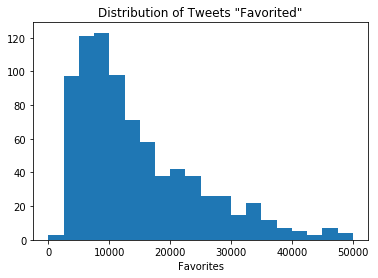

In [106]:
plt.hist(df_master['favorites'], range=[0,50000], bins=20);
plt.title('Distribution of Tweets "Favorited"');
plt.xlabel('Favorites');

/Users/Tim/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Tim/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


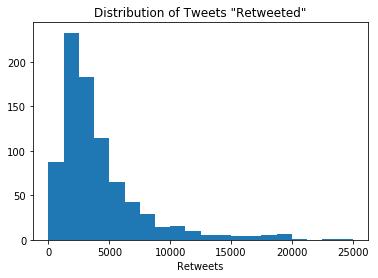

In [107]:
plt.hist(df_master['retweets'], range=[0,25000], bins=20);
plt.title('Distribution of Tweets "Retweeted"');
plt.xlabel('Retweets');

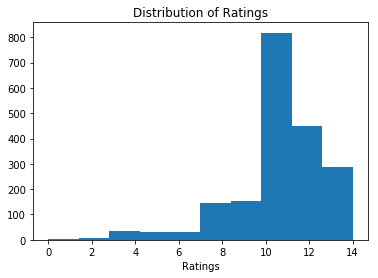

In [108]:
plt.hist(df_master['rating_numerator']);
plt.title('Distribution of Ratings');
plt.xlabel('Ratings');

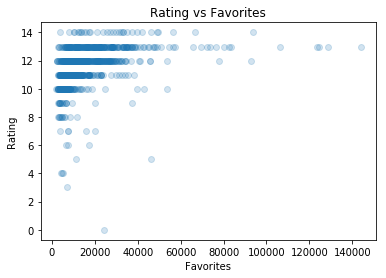

In [109]:
plt.scatter(df_master['favorites'], df_master['rating_numerator'], alpha=.2)
plt.title('Rating vs Favorites')
plt.ylabel('Rating');
plt.xlabel('Favorites');

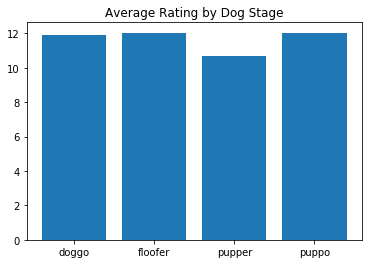

In [110]:
xlabels = ('doggo', 'floofer', 'pupper', 'puppo')
heights = [df_master[df_master['doggo'] == "doggo"]['rating_numerator'].mean(),
          df_master[df_master['floofer'] == "floofer"]['rating_numerator'].mean(),
          df_master[df_master['pupper'] == "pupper"]['rating_numerator'].mean(),
          df_master[df_master['puppo'] == "puppo"]['rating_numerator'].mean(),
          ]
plt.bar([1,2,3,4], heights, tick_label=xlabels);
plt.title('Average Rating by Dog Stage');

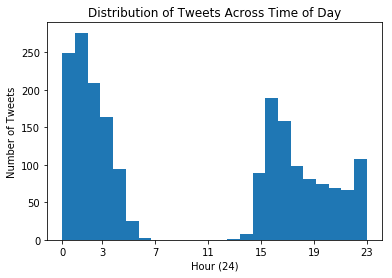

In [111]:
plt.hist(df_master['timestamp'].dt.hour, bins=24);
plt.xlabel('Hour (24)');
plt.ylabel('Number of Tweets');
plt.xticks((0,3,7,11,15,19,23));
plt.title('Distribution of Tweets Across Time of Day');

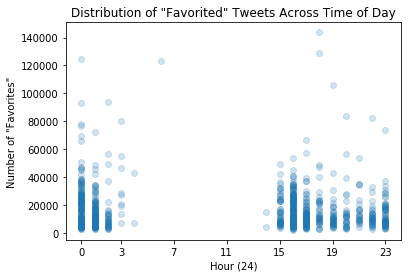

In [112]:
plt.scatter(df_master['timestamp'].dt.hour, df_master['favorites'], alpha=.2);
plt.xlabel('Hour (24)');
plt.ylabel('Number of "Favorites"');
plt.xticks((0,3,7,11,15,19,23));
plt.title('Distribution of "Favorited" Tweets Across Time of Day');

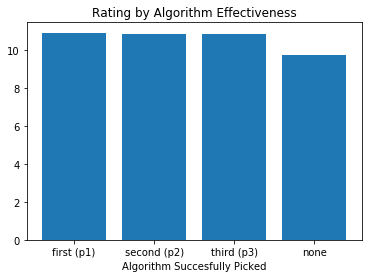

In [113]:
xlabels = ('first (p1)', 'second (p2)', 'third (p3)', 'none')
heights = [df_master[df_master['p1_dog'] == True]['rating_numerator'].mean(),
          df_master[df_master['p2_dog'] == True]['rating_numerator'].mean(),
          df_master[df_master['p3_dog'] == True]['rating_numerator'].mean(),
          df_master.query('p1_dog == False' and 'p2_dog == False' and 'p3_dog == False')['rating_numerator'].mean(),
          ]
plt.bar([1,2,3,4], heights, tick_label=xlabels);
plt.title('Rating by Algorithm Effectiveness');
plt.xlabel('Algorithm Succesfully Picked');

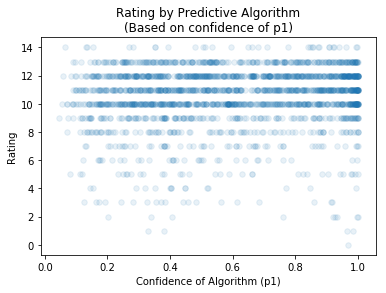

In [114]:
plt.scatter(df_master['p1_conf'], df_master['rating_numerator'], alpha=.1, s=30);
plt.title('Rating by Predictive Algorithm\n(Based on confidence of p1)');
plt.xlabel('Confidence of Algorithm (p1)');
plt.ylabel('Rating');

Accuracy at 10%  0.333333333333
Accuracy at 20%  0.528662420382
Accuracy at 30%  0.597733711048
Accuracy at 40%  0.641765704584
Accuracy at 50%  0.670440251572
Accuracy at 60%  0.697906281157
Accuracy at 70%  0.716595744681
Accuracy at 80%  0.730853391685
Accuracy at 90%  0.740226986129


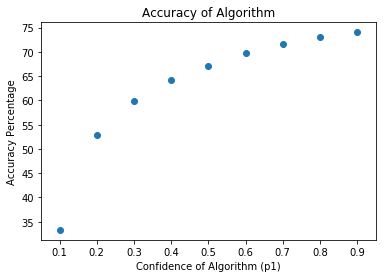

In [117]:
#determine the effectiveness of the algorithm
accuracy = []
for i in range(10,100, 10):
    df_sample = df_master.query('p1_conf < ' + str(i/100))
    score = (1 - df_sample['p1_dog'].value_counts()[0] / df_sample['p1_dog'].shape[0])
    accuracy.append(score)
    print('Accuracy at %s%% ' %i, score)

plt.scatter((.1,.2,.3,.4,.5,.6,.7,.8,.9), 100*numpy.array(accuracy));
plt.title('Accuracy of Algorithm');
plt.xlabel('Confidence of Algorithm (p1)');
plt.ylabel('Accuracy Percentage');